# Keras tuner

We usually need to tweak multiple hyperparameters to tweak.

Multiple tuning tools, for example Scikit-Learn.

However, there is also Keras tuner with several tuning strategies, customizability options and integration with TensorBoard.

https://keras.io/keras_tuner/
```
pip install keras-tuner --upgrade
```

In [ ]:
import tensorflow as tf
from pathlib import Path
import os

In [ ]:
fashion_mnist = tf.keras.datasets.fashion_mnist.load_data()

In [ ]:
(X_train_full, y_train_full), (X_test, y_test) = fashion_mnist
X_train, y_train = X_train_full[:10000], y_train_full[:10000] 
X_valid, y_valid = X_train_full[:1000], y_train_full[:1000]

You need to also import Keras tuner separately.

In [ ]:
import keras_tuner as kt

## How to tune different hyperparameters

https://keras.io/api/keras_tuner/hyperparameters/

Build a model with tunable:
* number of hiddent layers *n_hidden*
* number of neurons *n_neurons*
* learnig rate *learning_rate*
* pick and optimizer, either SGD or Adam *optimizer*

In [ ]:
# create function for building model taking keras_tuner.HyperParameters as an argument
def build_model(hp):
    # defining number is pretty straightforward, you just set:
    """    
    defining number is pretty straightforward, you just set: 
    
    - type - hp.Int or hp.Float
    - min_value - a minimum value for parameter
    - max_value - a maximum value for parameter
    - default - default value
    
    tuner checks, if parameter with the given name exists and if not, it will create one, otherwise it just returns a value
    """
    n_hidden = hp.Int('n_hidden', min_value=0, max_value=8, default=2)
    n_neurons = hp.Int('n_neurons', min_value=16, max_value=256, step=16)
    
    # log sampling will assign equal probabilities to each order of magnitude range
    learning_rate = hp.Float('learning_rate', min_value=1e-4, max_value=1e-2, sampling='log')
    
    # we know the set from which we would like to choose optimizer
    optimizer = hp.Choice('optimizer', values=['sgd', 'adam'])
    # we create optimizer instance because we would like to use selected learning rate in it
    if optimizer == 'sgd':
        optimizer = tf.keras.optimizers.SGD(learning_rate=learning_rate)
    else:
        optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
    
    # just create the model - input is always the same - we are using images 28x28, there is nothing to tune
    input_layer = tf.keras.layers.Input(shape=(28, 28))
    # we also need to flatten the image
    x = tf.keras.layers.Flatten()(input_layer)
    
    # we got number of hidden layers, so we create model the same same number of hidden layers
    for _ in range(n_hidden):
        # each layer will also have the same number of neurons - also tunable parameter in this case
        x = tf.keras.layers.Dense(n_neurons, activation='relu')(x)
    # nothing to tune here - it is just a multiclass classification layer
    output_layer = tf.keras.layers.Dense(10, activation='softmax')(x)
    # create model
    model = tf.keras.models.Model(inputs = input_layer, outputs = output_layer)
    # set the optimizer selected by tuner, compile the model and return
    model.compile(loss='sparse_categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])
    return model

## RandomSearch

The most basic of tuners.

Could work well for complicated models where we just don't have time and resources to try every variant, to get us at least a clue what might work.

In the example we will test 5 different randomly created models for 10 epochs of training per each model.

In [ ]:
%%time
random_search_tuner = kt.RandomSearch(
    # function returning the model to tune
    build_model,
    # objective for evaluating models
    objective='val_accuracy',
    # number of trials - each trial will tuner sample random values from ranges we set and runs the training
    max_trials=5, 
    # delete previous tuner runs, otherwise it would just continue with previous runs - so you don't need to finish
    # the tuning in a single run
    overwrite=True,
    # output directory
    directory='fashion_mnist_tuning', 
    # prefix for files in the directory
    project_name='rnd_search', 
    seed=42)
random_search_tuner.search(X_train, y_train, epochs=10, validation_data=(X_valid, y_valid))

We can restore the top N architectures by running ```get_best_models``` function.

In [ ]:
top_three_models = random_search_tuner.get_best_models(num_models=3)
best_model = top_three_models[0]

In [ ]:
best_model.summary()

Or get the best hyperparameters by running ```get_best_hyperparameters```.

In [ ]:
top3_params = random_search_tuner.get_best_hyperparameters(num_trials=3)
top3_params[0].values

### Oracle

Each tuner is guided by oracle - oracle tells the tuner what next trial should be. 

It keeps track of all the trials, so we can ask for summary of the best one.

In [ ]:
best_trial = random_search_tuner.oracle.get_best_trials(num_trials=1)[0]
best_trial.summary()

We can also access all metrics.

In [ ]:
best_trial.metrics.get_last_value("val_accuracy")

If you are happy with the chosen model, you can try to train it longer on a bigger data to see how it perform.

Model is compiled, so everything is set, you just need to run fit function.

In [ ]:
best_model.fit(X_train_full, y_train_full, epochs=5)
test_loss, test_accuracy = best_model.evaluate(X_test, y_test)

In [ ]:
print(f'test accuracy: {100*test_accuracy:.2f}%')

## How to tune training or data preprocessing

For tuning of training and preprocessing, we need to use custom HyperModel.

You need to implement two functions:
* ```build``` returns the model, basically the same as already implemented build_model
* ```fit``` take HyperParameters object and applies to the compiled model

In [ ]:
class CustomHyperModel(kt.HyperModel):
    def build(self, hp):
        return build_model(hp)
    # we may use hyperparameters to tune training process, in this case we may try to add a normalization to data before training
    def fit(self, hp, model, X, y, **kwargs):
        if hp.Boolean('normalize'):
            norm_layer = tf.keras.layers.Normalization()
            X = norm_layer(X)
        return model.fit(X, y, **kwargs)

## Hyperband

More sophisticated tuner.

It tries to train many different models for few epochs and eliminates the worst models while keeping top 1/factor models.

In [ ]:
hyperband_tuner = kt.Hyperband(
    # use custom HyperModel
    CustomHyperModel(), 
    objective='val_accuracy', 
    seed=42,
    # set maximum number of epochs the best model will be trained for
    max_epochs=5, 
    # keep only top third of models
    factor=3, 
    # how many times to run the whole tuning process
    hyperband_iterations=2,
    overwrite=True, 
    directory='fashion_mnist_tuning', 
    project_name='hyperband')

We can save the hyberband tuning process to TensorBoard

In [ ]:
%%time
tensorboard = tf.keras.callbacks.TensorBoard(os.path.join(hyperband_tuner.project_dir, 'tensorboard'))
# kill unpromissing trainings sooner
early_stopping = tf.keras.callbacks.EarlyStopping(patience=2)

hyperband_tuner.search(
    X_train, 
    y_train, 
    epochs=5,
    validation_data=(X_valid, y_valid),
    callbacks=[early_stopping, tensorboard])

You can browse the results in TensorBoard and look at plenty of plots that could help you understand what works.

```
tensorboard --logdir fashion_mnist_tuning/hyperband/tensorboard
```

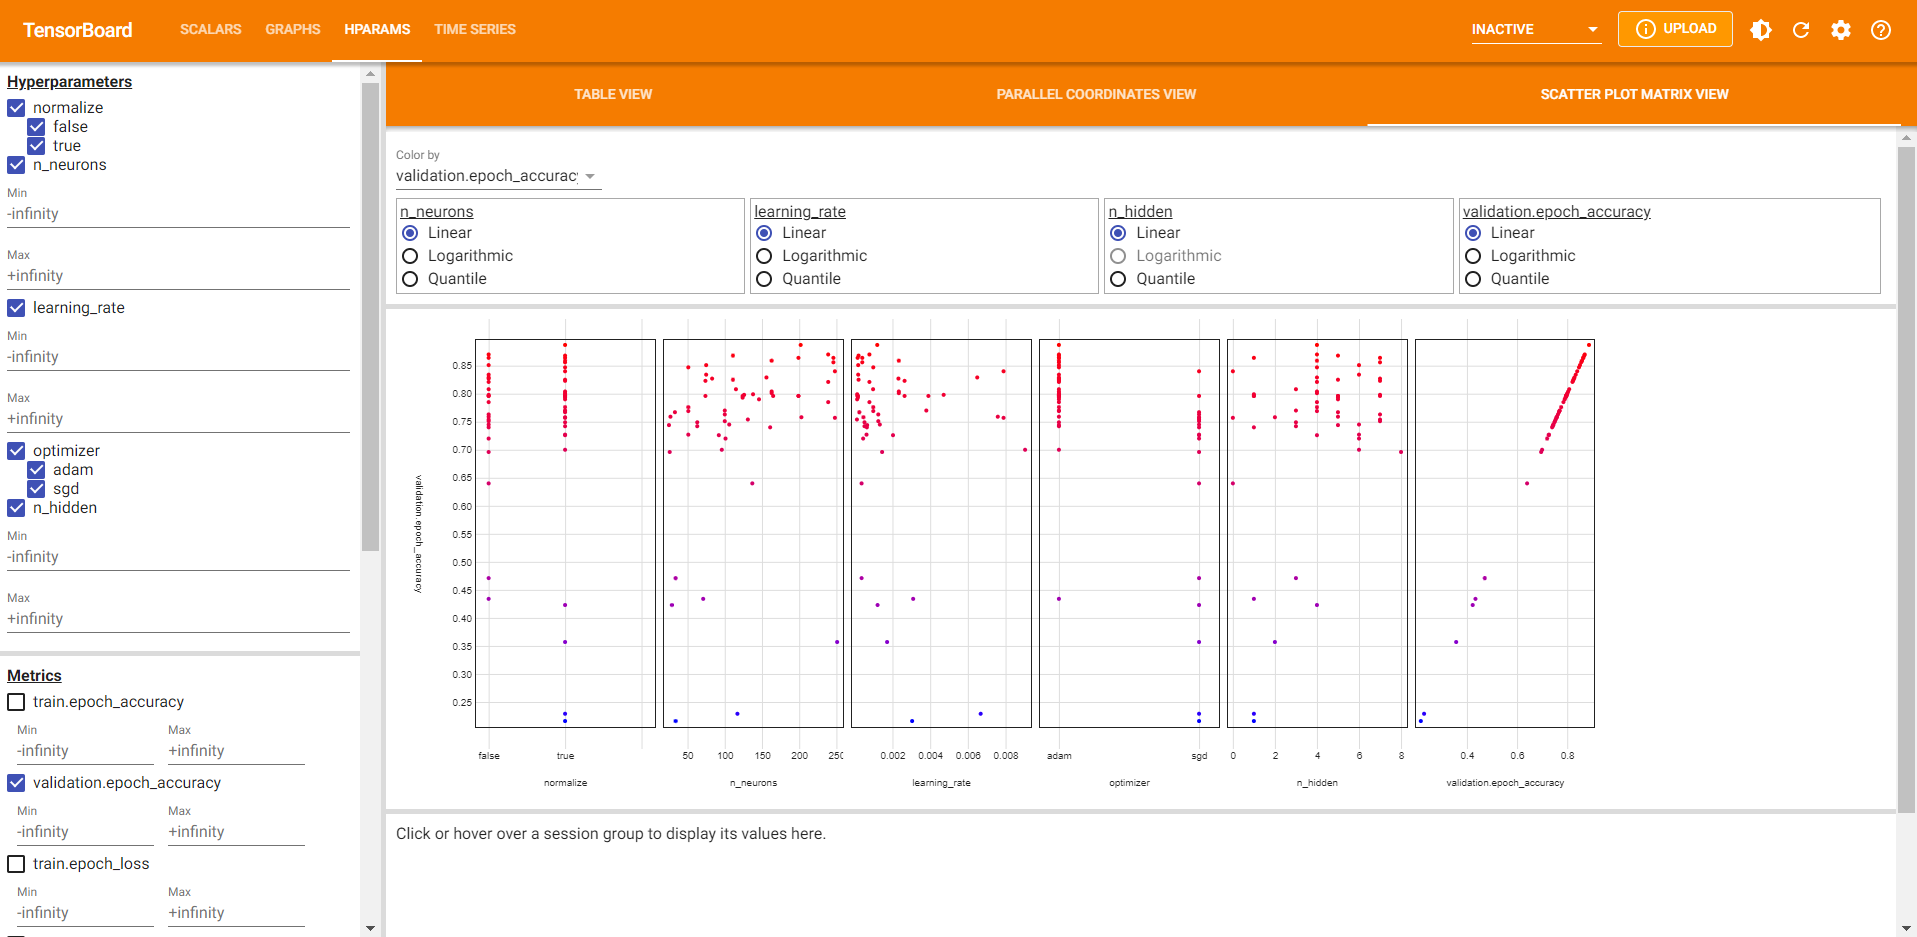

## BayesianOptimization

Hyperband is smarter than pure random, but it is still more or less pure random search.

Bayesian optimization gradualy learns which regions of hyperparameter space are most promising using Gaussian process.

The downside is introduction of two hyperparameters:
* alpha - level of noise
* beta - how much you wat the algorithm to explore

http://www.cs.toronto.edu/~rgrosse/courses/csc321_2017/slides/lec21.pdf

In [ ]:
bayesian_opt_tuner = kt.BayesianOptimization(
    CustomHyperModel(), 
    objective="val_accuracy", 
    seed=42,
    max_trials=5, 
    alpha=1e-4, 
    beta=2.6,
    overwrite=True, 
    directory="fashion_mnist_tuning", 
    project_name="bayesian_opt")


In [ ]:
%%time
early_stopping = tf.keras.callbacks.EarlyStopping(patience=2)
tensorboard = tf.keras.callbacks.TensorBoard(os.path.join(bayesian_opt_tuner.project_dir, 'tensorboard'))

bayesian_opt_tuner.search(
    X_train, 
    y_train, 
    epochs=10,
    validation_data=(X_valid, y_valid),
    callbacks=[early_stopping, tensorboard])